In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve
)

import joblib
import shap

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
sns.set(style="whitegrid", context="talk")
import joblib

In [25]:
data_dir = "C://Users//aditi//OneDrive//Desktop//fraud_detection//processed"
model_dir = "C://Users//aditi//OneDrive//Desktop//fraud_detection//models"

X_test = pd.read_csv(f"{data_dir}/X_test.csv")
y_test = pd.read_csv(f"{data_dir}/y_test.csv").values.ravel()

lr_model = joblib.load(f"{model_dir}/logistic_model.pkl")
rf_model = joblib.load(f"{model_dir}/random_forest_model.pkl")
xgb_model = joblib.load(f"{model_dir}/xgboost_fraud_model.pkl")

X_test.shape, y_test.shape

((100, 17), (100,))

In [26]:
fraud_rate = y_test.mean()
fraud_rate

0.05

In [27]:
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

results = []

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred)
    })

comparison_df = pd.DataFrame(results)
comparison_df


,Model,ROC-AUC,Precision,Recall,F1-Score,Accuracy
0,Logistic Regression,0.4232,0.0513,0.4000,0.0909,0.6000
1,Random Forest,0.5074,0.0000,0.0000,0.0000,0.9400
2,XGBoost,0.4505,0.0000,0.0000,0.0000,0.9300


In [28]:
FP_COST = 10
FN_COST = 500

def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * FP_COST + fn * FN_COST


In [29]:
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
default_preds = (xgb_probs >= 0.5).astype(int)

business_cost(y_test, default_preds)


2520

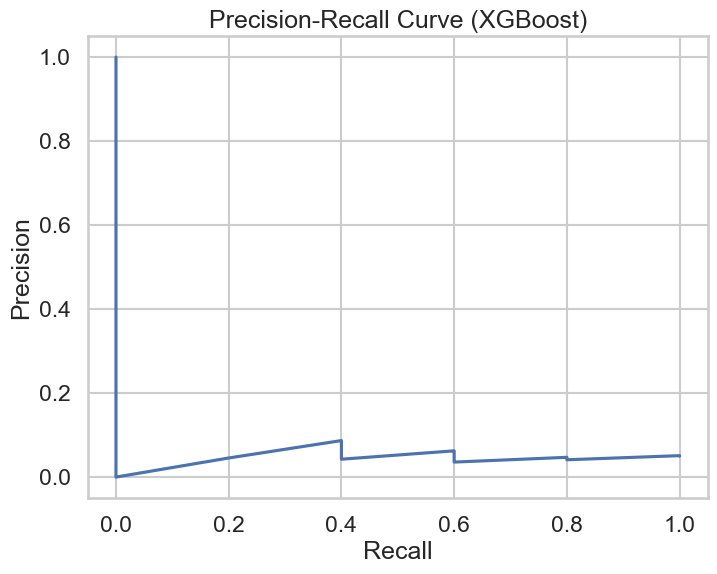

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()


In [31]:
threshold_costs = []

for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    cost = business_cost(y_test, preds)
    threshold_costs.append(cost)

threshold_costs = np.array(threshold_costs)

optimal_idx = np.argmin(threshold_costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = threshold_costs[optimal_idx]   


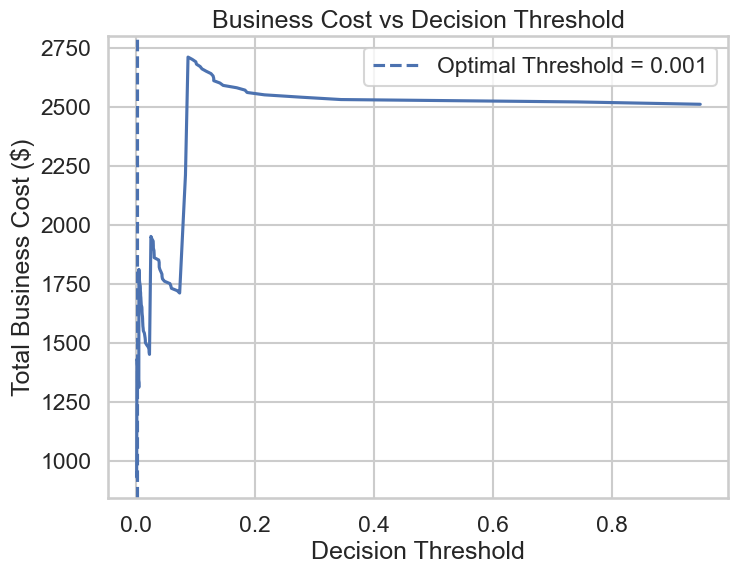

In [32]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, threshold_costs)
plt.axvline(optimal_threshold, linestyle="--", label=f"Optimal Threshold = {optimal_threshold:.3f}")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("Business Cost vs Decision Threshold")
plt.legend()
plt.show()


In [33]:
optimal_preds = (xgb_probs >= optimal_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, optimal_preds).ravel()

precision = precision_score(y_test, optimal_preds)
recall = recall_score(y_test, optimal_preds)
f1 = f1_score(y_test, optimal_preds)
auc = roc_auc_score(y_test, xgb_probs)

fraud_catch_rate = tp / (tp + fn)
false_alarm_rate = fp / (fp + tn)

threshold_file = f"{model_dir}/final_threshold.txt"

with open(threshold_file, "w") as f:
    f.write(f"optimal_threshold={optimal_threshold:.10f}\n")
    f.write("optimization_objective=minimize_total_business_cost\n")
    f.write(f"minimum_business_cost={min_cost:.2f}\n\n")

    f.write("confusion_matrix:\n")
    f.write(f"  tn={tn}\n")
    f.write(f"  fp={fp}\n")
    f.write(f"  fn={fn}\n")
    f.write(f"  tp={tp}\n\n")

    f.write("classification_metrics:\n")
    f.write(f"  precision={precision:.4f}\n")
    f.write(f"  recall={recall:.4f}\n")
    f.write(f"  f1_score={f1:.4f}\n")
    f.write(f"  roc_auc={auc:.4f}\n\n")

    f.write("business_metrics:\n")
    f.write(f"  fraud_catch_rate={fraud_catch_rate:.4f}\n")
    f.write(f"  false_alarm_rate={false_alarm_rate:.4f}\n\n")

    f.write("metadata:\n")
    f.write("  model=XGBoost\n")
    f.write("  evaluation_set=test\n")
    f.write("  threshold_method=quantile_cost_optimization\n")

print("Threshold analysis saved successfully.")


Threshold analysis saved successfully.


In [34]:
model = xgb_model.named_steps["model"] if hasattr(xgb_model, "named_steps") else xgb_model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


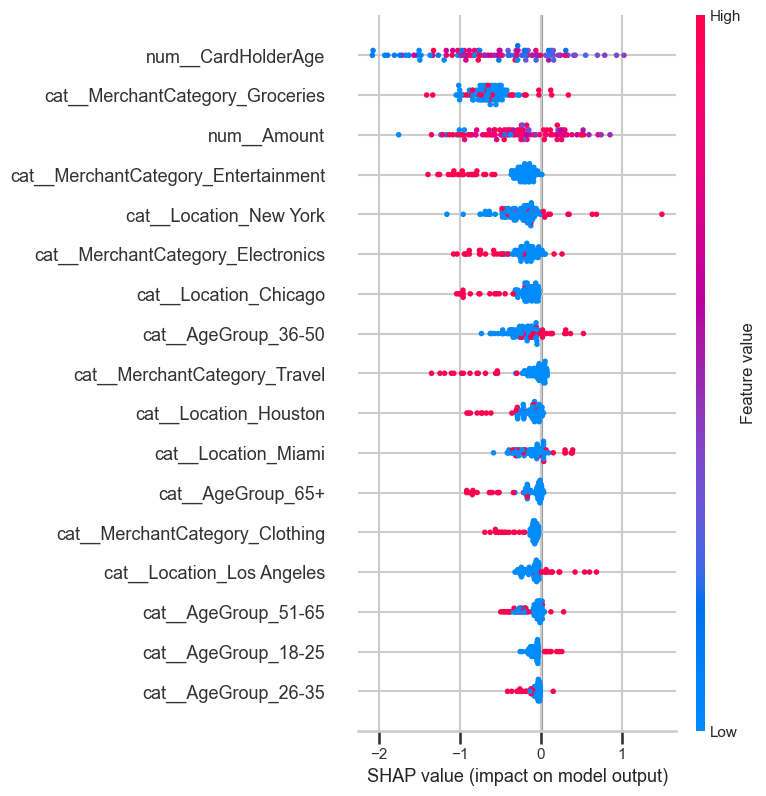

In [35]:
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

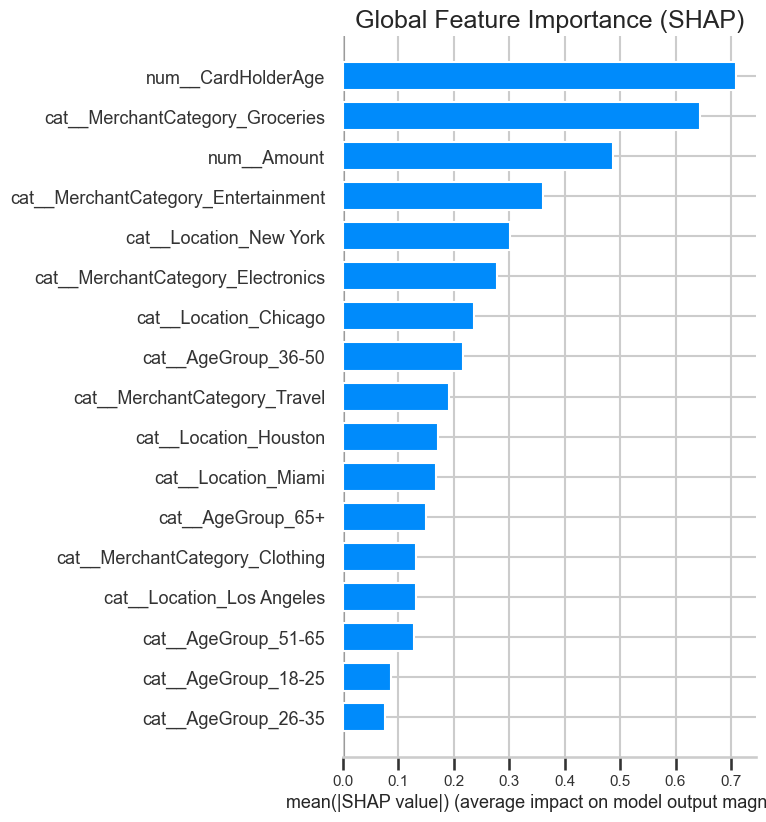

In [36]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    show=False
)
plt.title("Global Feature Importance (SHAP)")
plt.show()


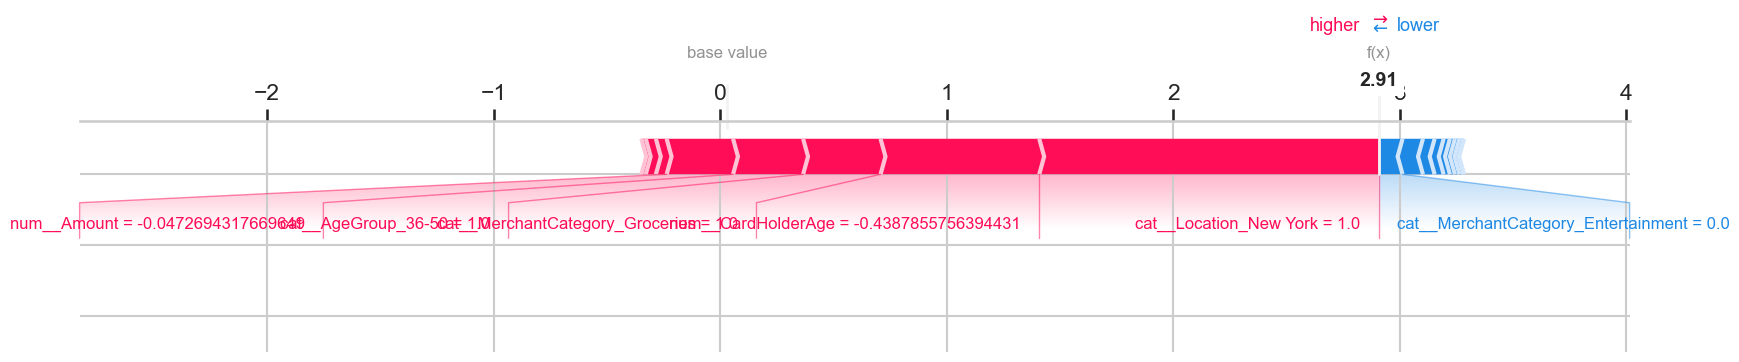

In [37]:
sample_idx = np.argmax(xgb_probs)

shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test.iloc[sample_idx],
    matplotlib=True
)


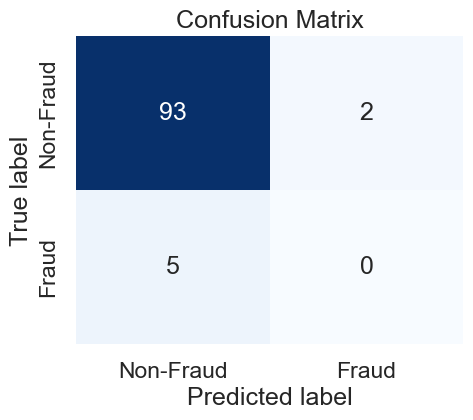

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0,          # 🔴 removes grid lines
    xticklabels=["Non-Fraud", "Fraud"],
    yticklabels=["Non-Fraud", "Fraud"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()


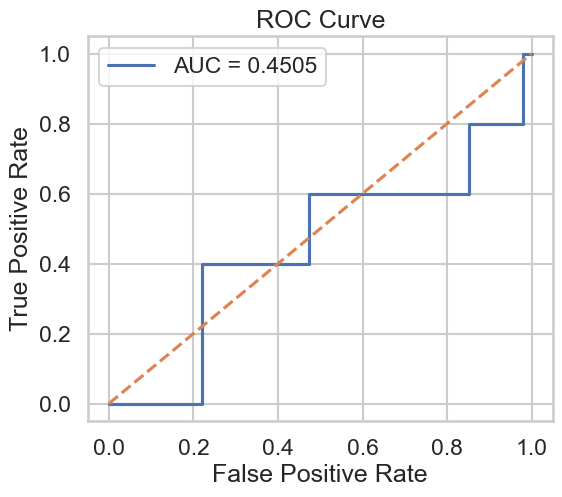

0.4505263157894737

In [39]:
y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

auc_score


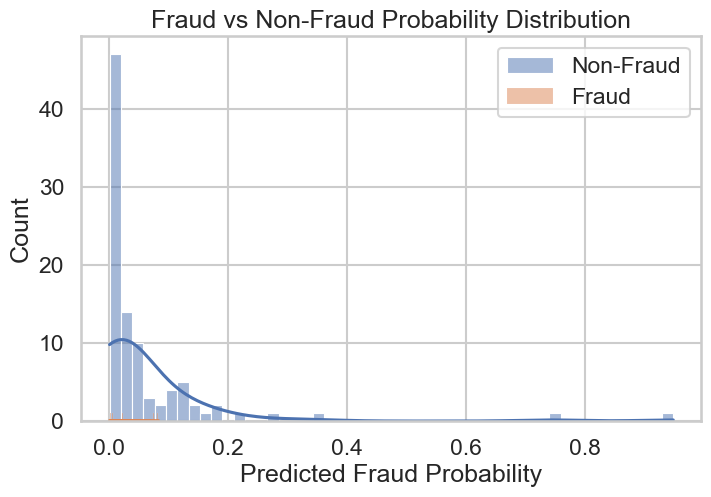

In [40]:
plt.figure(figsize=(8, 5))

sns.histplot(y_proba[y_test == 0], bins=50, label="Non-Fraud", kde=True)
sns.histplot(y_proba[y_test == 1], bins=50, label="Fraud", kde=True)

plt.xlabel("Predicted Fraud Probability")
plt.title("Fraud vs Non-Fraud Probability Distribution")
plt.legend()
plt.show()


In [41]:
feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance.head(10)

,Feature,Importance
10,cat__MerchantCategory_Groceries,0.1610
9,cat__MerchantCategory_Entertainment,0.1027
8,cat__MerchantCategory_Electronics,0.0869
11,cat__MerchantCategory_Travel,0.0799
2,cat__Location_Chicago,0.0758
3,cat__Location_Houston,0.0596
6,cat__Location_New York,0.0588
16,cat__AgeGroup_65+,0.0588
7,cat__MerchantCategory_Clothing,0.0568
15,cat__AgeGroup_51-65,0.0539


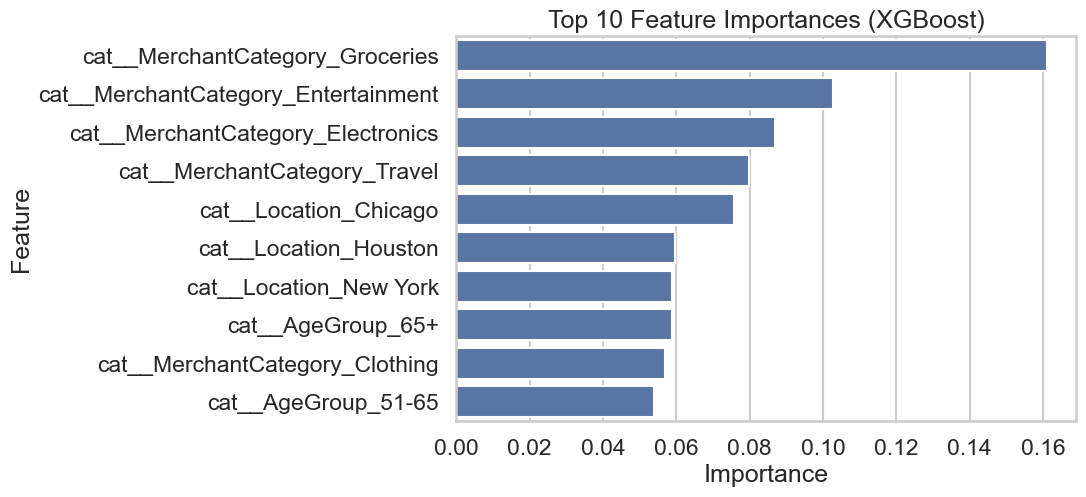

In [42]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance.head(10)
)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

In [43]:
X_test_copy = X_test.copy()
X_test_copy["Actual"] = y_test
X_test_copy["Predicted"] = y_pred
X_test_copy["Predicted_Probability"] = y_proba

false_positives = X_test_copy[
    (X_test_copy["Actual"] == 0) & (X_test_copy["Predicted"] == 1)
]

false_negatives = X_test_copy[
    (X_test_copy["Actual"] == 1) & (X_test_copy["Predicted"] == 0)
]

print("False Positives:", false_positives.shape[0])
print("False Negatives:", false_negatives.shape[0])


False Positives: 2
False Negatives: 5


In [44]:
false_positives.head()


,num__Amount,num__CardHolderAge,cat__Location_Chicago,cat__Location_Houston,cat__Location_Los Angeles,cat__Location_Miami,cat__Location_New York,cat__MerchantCategory_Clothing,cat__MerchantCategory_Electronics,cat__MerchantCategory_Entertainment,cat__MerchantCategory_Groceries,cat__MerchantCategory_Travel,cat__AgeGroup_18-25,cat__AgeGroup_26-35,cat__AgeGroup_36-50,cat__AgeGroup_51-65,cat__AgeGroup_65+,Actual,Predicted,Predicted_Probability
6,-0.0473,-0.4388,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0,1,0.9482
24,-0.3475,-0.2222,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0,1,0.7411


In [45]:
false_negatives.head()


,num__Amount,num__CardHolderAge,cat__Location_Chicago,cat__Location_Houston,cat__Location_Los Angeles,cat__Location_Miami,cat__Location_New York,cat__MerchantCategory_Clothing,cat__MerchantCategory_Electronics,cat__MerchantCategory_Entertainment,cat__MerchantCategory_Groceries,cat__MerchantCategory_Travel,cat__AgeGroup_18-25,cat__AgeGroup_26-35,cat__AgeGroup_36-50,cat__AgeGroup_51-65,cat__AgeGroup_65+,Actual,Predicted,Predicted_Probability
22,0.7853,-1.1967,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1,0,0.0013
23,0.3997,-0.9260,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1,0,0.0735
47,0.2595,-0.0057,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1,0,0.0833
85,-1.2694,0.5898,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1,0,0.0049
93,-0.0193,-0.8177,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1,0,0.0228


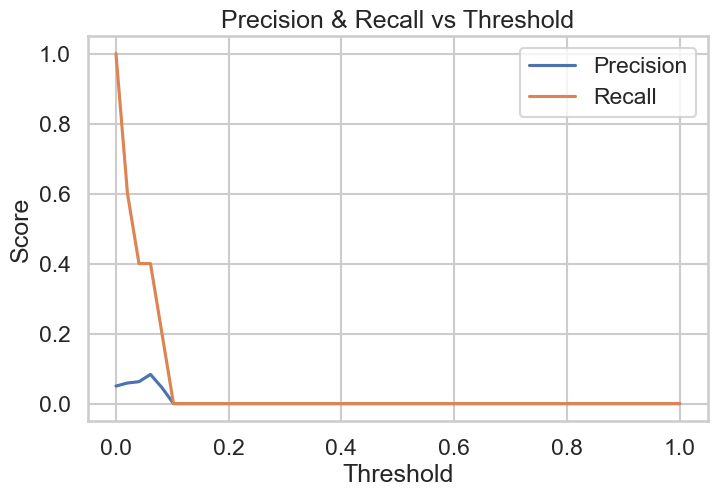

In [46]:
thresholds = np.linspace(0, 1, 50)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds, zero_division=0))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()